In [10]:
import os
import numpy as np
import pandas as pd

def getDatasetPath(chosenDataset, withNoise):
    """getDatasetPath function return the folderPath and filePath of the Trajectory Dataset chosen by the user via chosenDataset integer (number of dataset), withNoise flag"""
    # folderNames is a dict containing as keys numbers from 1 to 7 and as values the folder names of the trajectory datasets
    folderNames = {1: "TRAJECTORY 1", 2: "TRAJECTORY 2", 3:"TRAJECTORY 3", 4: "TRAJECTORY 4", 5: "TRAJECTORY 5", 6: "TRAJECTORY 6", 7: "TRAJECTORY 7"}
    # datasets is a dict containing as keys numbers from 1 till 7 and as values tuples containing the text files names of the datasets
    datasets = {1: ("static_100Hz", "static_100Hz_with_noise"), 2: ("straight_50Hz", "straight_50Hz_with_noise"), 3: ("car_turns_100Hz", "car_turns_100Hz_with_noise"),
                    4: ("fast_car_50Hz", "fast_car_50Hz_with_noise"), 5: ("air_turns_50Hz", "air_turns_50Hz_with_noise"),
                    6: ("climb_and_descent_50Hz", "climb_and_descent_50Hz_with_noise"), 7: ("whole_flight_20Hz", "whole_flight_20Hz_with_noise")}
    # os.getcwd() returns the current working directory(path) in which the project is found. folderPath concatenates to the current path, /measurements/
    # and then folderName of the chosen dataset by the user
    folderPath = os.getcwd() + '/measurements/' + str(folderNames[chosenDataset]) + '/'
    # the path to the text file dataset is the folderPath concatenated to the tuple returned by the datasets(which is a dictiornary) of [chosenDataset(which is a key)]
    # depending on the withNoise flag passed by the user, either the first name from the tuple is passed (withNoise is False) either the second name (withNoise is True)
    filePath = folderPath + str(datasets[chosenDataset][1]) if withNoise else folderPath + str(datasets[chosenDataset][0])
    return folderPath, filePath

def getDataframe(filePath):
    """getDataframe function return the most relevant paramenters from the Trajectory Datasets, namely Fs, P0, V0, V0, E0 and the dataframe of the actual measurements by accepting the filePath as an argument"""
    with open(filePath, 'r') as f:  # firstly open the text file found at filePath for reading (r) from it
        contents = f.readlines()    # read all the lines of the text file and return them as a list of strings stored in the contents variable
    Fs = np.zeros(shape=[1])        # sampling frequency initialized as a [0] array
    P0 = np.zeros(shape=[1, 3])     # initial position of IMU initialized as a row vector of [0, 0, 0]
    V0 = np.zeros(shape=[1, 3])     # initial velocity of IMU initialized as a row vector of [0, 0, 0]
    E0 = np.zeros(shape=[1, 3])     # initial Euler Angles initialized as a row vector of [0, 0, 0]
    indexStartMeasurements = []     # temporary dummy variable used to store the index(the line number) from the text file from which the measurements start (empty array)

    for index, line in enumerate(contents):     # iterating through the contents lists of strings while keeping track of each line index and line string array
        if len(indexStartMeasurements) == 1:    # if the indexStartMeasurements is not empty anymore (its length is 1) it means that iterator has passed the line from which the measurements start
            break                               # since the line index of the text file from which the measurements start is found, exit from the loop
        if line.find("# Sampling frequency (Hz) :") >= 0:   # if "Sampling frequency (Hz) :" string is found in the current line
            Fs[0] = float(contents[index + 1])              # update Fs by taking the float value of the contents string array found at the next index, Fs value found on the next line after Sampling frequency (Hz)
            continue
        if line.find("# IMU initial position :") >= 0:      # if "IMU initial position :" string is found in the current line
            P0[0] = eval(contents[index + 1])               # update P0 by converting via eval() the contents string array at the next index to a float array
            continue
        if line.find("# IMU initial velocity :") >= 0:      # if "IMU initial velocity :" string is found in the current line
            V0[0] = eval(contents[index + 1])               # update V0 by converting via eval() the contents string array at the next index to a float array
            continue
        if line.find("# IMU initial Euler's angles :") >= 0:    # if "IMU initial Euler's angles :" is found in the current line
            E0[0] = eval(contents[index + 1])                   # update E0 by converting via eval() the contents string array at the next index to a float array
        if line.find("Time (GPS)") >= 0:                        # if "Time (GPS) :" is found in the current line
            indexStartMeasurements.append(index)                # append to the empty array the line index of the text file from which the measurements start
            continue
    df = pd.read_csv(filepath_or_buffer=filePath, sep="\t", header=indexStartMeasurements[0])   # make a df measurements dataframe out of the text file specified via filePath and the indexStartMeasurements
    df = df.loc[:, ~df.columns.str.startswith('Unnamed')]                                       # drop the additional, redundant and unnecessary columns in the dataframe that start with Unnamed
    df.to_csv('data.csv')                                                                       # save the measurements dataframe as a csv in the project
    return Fs, P0, V0, E0, df


In [11]:
import numpy as np

class KalmanFilter:
    def __init__(self, P0, V0, E0, R, dt):
        # state matrix
        self.A = np.array([[1, 0, 0, dt, 0, 0, 0, 0, 0],
                          [0, 1, 0, 0, dt, 0, 0, 0, 0],
                          [0, 0, 1, 0, 0, dt, 0, 0, 0],
                          [0, 0, 0, 1, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 1, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 0, 0, 0, 1, 0, 0],
                          [0, 0, 0, 0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 0, 0, 0, 1]])
        # control matrix
        self.B = np.array([[0*0.5*dt*dt, 0, 0, 0, 0, 0],
                          [0, 0*0.5*dt*dt, 0, 0, 0, 0],
                          [0, 0, 0*0.5*dt*dt, 0, 0, 0],
                          [dt, 0, 0, 0, 0, 0],
                          [0, dt, 0, 0, 0, 0],
                          [0, 0, dt, 0, 0, 0],
                          [0, 0, 0, dt, 0, 0],
                          [0, 0, 0, 0, dt, 0],
                          [0, 0, 0, 0, 0, dt]])
        self.n = np.shape(self.A)[0]                                        # row dimension of the A matrix (9 states)
        self.x_initial = np.array([P0[0], V0[0], E0[0]]).reshape(self.n, 1) # the state vector X from the previous iteration
        self.x = np.array([P0[0], V0[0], E0[0]]).reshape(self.n, 1)         # the state vector X as a 9x1 vector [x, y, z, vx, vy, vz, phi, theta, psi].T
        # output matrix
        self.C = np.array([[2/(dt^2), 0, 0, 1/dt, 0, 0, 0, 0, 0],
                          [0, 2/(dt^2), 0, 0, 1/dt, 0, 0, 0, 0],
                          [0, 0, 2/(dt^2), 0, 0, 1/dt, 0, 0, 0],
                          [0, 0, 0, 0, 0, 0, 1/dt, 0, 0],
                          [0, 0, 0, 0, 0, 0, 0, 1/dt, 0],
                          [0, 0, 0, 0, 0, 0, 0, 0, 1/dt]])

        self.P = 500 * np.eye(self.n)                           # covariance state matrix
        # discrete noise model is used, dt is small
        self.var_w = 10                                          # variance of the process noise w E[w*w.T]
        self.Q = (self.var_w ^ 2) * np.dot(self.B, self.B.T)    # process noise covariance matrix E[v*v.T]
        self.R = R                                              # measurement noise covariance matrix

    # prediction step
    def aprioriEstimation(self, u):
        self.x = np.dot(self.A, self.x) + np.dot(self.B, u)         # state vector estimation
        self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q  # state covariance estimation

    # update step
    def aposterioriEstimation(self, y):
            S = np.linalg.inv(np.dot(np.dot(self.C, self.P), self.C.T) + self.R)
            self.K = np.dot(np.dot(self.P, self.C.T), S)                            # computing the Kalman Gain
            self.x = self.x + np.dot(self.K, (y - np.dot(self.C, self.x)))          # state vector estimation
            self.P = np.dot(np.eye(self.n) - np.dot(self.K, self.C), self.P)        # covariance matrix estimation

def estimation(KF, y, observations):
    print("ESTIMATION!!!")
    """estimation function returns the state vector containing all the states predicted by the KF Kalman Filter, based on the
    y measurements matrix and u input command vector"""
    g = np.empty(shape=[KF.n, 1])
    state = np.empty(shape=[KF.n, 1])       # initializing the state covariance vector as a column vector of KF.n rows
    #covariance = np.empty(shape=[KF.n, 1])  # initializing the covariance matrix as a
    for index in range(0, y.shape[0]):      # iterating from 0 till the number of data points in the measurements matrix
        u = np.array(y[index].reshape(y.shape[1], 1))    # aposterioriEstimation function requires a column vector of shape (states measured by sensors)x1, that's why reshape is used
        if index < y.shape[0] - 1:
            u[3:, :] = ECEF02ECEF(u[3:, :], GPS_time[index + 1] - GPS_time[index]) # converting the gyro data from ECEF0 to ECEF
        if index == y.shape[0] - 1:
            u[3:, :] = ECEF02ECEF(u[3:, :], GPS_time[index] - GPS_time[index - 1])
        # change y to u, after the dot product, specific forces in ECEF, remove grav in 
        rot_ECEF2BODY = ECEF2body(u[0:3, :], x_initial[6][0], x_initial[8][0], x_initial[7][0]) # rotation matrix from ECEF to BODY
        rot_ECEF2BODY = np.array(list(rot_ECEF2BODY[:, :]), dtype=np.float64) # making a numpy array
        u[0:3, :] = np.dot(np.linalg.inv(rot_ECEF2BODY), u[0:3, :]) # converting the Specific force from BODY frame to ECEF frame
        # 0, 0, 9.81 grav in ENU, apply it to ENU2ECEF and add it to a measurement
        # print ecef gravity, -9.81, 0, 0, all trajectories are staying still for 60s, specific forces are always 0
        gravity_vector = np.array([[0], [0], [9.809792]])
        [phi_reference, lamda_reference, h_reference] = ECEF2LLA(gravity_vector)
        
        rot_ECEF2ENU = np.zeros((3, 3))
        rot_ECEF2ENU[0, :] = [-np.sin(lamda_reference), np.cos(lamda_reference), 0]
        rot_ECEF2ENU[1, :] = [-np.sin(phi_reference)*np.cos(lamda_reference),
                             -np.sin(phi_reference)*np.sin(lamda_reference), np.cos(phi_reference)]
        rot_ECEF2ENU[2, :] = [np.cos(phi_reference) * np.cos(lamda_reference),
                             np.cos(phi_reference) * np.sin(lamda_reference), np.sin(phi_reference)]
        gravity_ECEF = np.dot(np.linalg.inv(rot_ECEF2ENU), gravity_vector)
        print(gravity_ECEF)
        u[0:3, :] = u[0:3, :] + gravity_ECEF # removing the gravity component from the accelerometer data
        # GPS_time[index] - GPS_time[index-1] how much the ECEF frame has rotated between 2 time steps.
        
        KF.aprioriEstimation(u)             # apply the apriori estimation to the KF
        # the y numpy array passed to this function has a Nx6 where N is the number of datapoints in the measurements matrix
        
        KF.aposterioriEstimation(observations)                      # apply the aposteriori estimation to the KF
        state = np.concatenate([state, KF.x], axis=1)               # concatenate a new column of predicted state vector (KF.x) to the state => state vector becomes a state matrix
        KF.x_initial = KF.x                                         # updating the KF.x_initial to the currently estimated KF.x
        g = np.concatenate([g, gravity_ECEF], axis=1) 
        #covariance = np.concatenate([state, KF.P], axis=1)
    state = np.delete(state, 0, axis=1)
    g = np.delete(g, 0, axis=1)
    #covariance = np.delete(covariance, 0, axis=1)
    return state


In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from getMeasurements import getDatasetPath, getDataframe
from KalmanFilter import *
from conversion import *

# User specified chosenDataset and withNoise flag
chosenDataset = 2   # specify which Trajectory dataset to use
withNoise = True    # Do you want noise to your data or not?

# Press the green button in the gutter to run the script
if __name__ == '__main__':
    folderPath, filePath = getDatasetPath(chosenDataset, withNoise) # get the folderPath and filePath of the chosen Trajectory dataset
    print(folderPath, filePath)                                     # check whether the folderPath and filePath are what they should be
    Fs, P0, V0, E0, y = getDataframe(filePath)                      # get the most relevant parameters out of the text file, note that y is the dataframe of measurements
    dt = 1/Fs[0]                                                    # the time increment used for Kalman Filtering apriori estimation
    print(y.shape)                                                  # check if the measurements dataframe is the intended shape
    measurements = y.iloc[:, 1:]                                    # observations is a new DataFrame which contains all the rows and columns of y, but except the "Time GPS" columns
    measurementsNumpied = measurements.to_numpy()                   # convert the observations DataFrame into a numpy array
    GPS_time = y.iloc[:, 0]                                         # GPS time fron the dataset
    
    observations = 0*np.ones([measurementsNumpied.shape[1], 1])                 # initializing the input command vector as a 6x1 numpy array
    #rot_matrix = ECEF2body(u[0:3, :], E0[0][0], E0[0][1], E0[0][2]) # rotation matrix from ECEF to BODY
    #rot_matrix = np.array(list(rot_matrix[:, :]), dtype=np.float64) # making a numpy array
    #u[0:3, :] = np.dot(np.linalg.inv(rot_matrix), u[0:3, :]) # converting the Specific force from BODY frame to ECEF frame
    #u[2, :] = u[2, :] + 9.809792 # removing the gravity component from the accelerometer data
    #u[3:, :] = ECEF2ECEF0(u[3:, :], GPS_time[0]) # converting the gyro data from ECEF0 to ECEF
    
    R = y.iloc[:, 1:].cov()                                         # measurements covariance matrix
    KF = KalmanFilter(P0, V0, E0, R, dt)                            # Instantiating the KF object that implements the apriori and aposteriori steps of Kalman Filtering
    state = estimation(KF, measurementsNumpied, observations)                  # estimate the state vector and covariance matrix from the Kalman Filter
    #print(gravity_ECEF)                                                    # print the state

/home/vlad/ENAC/IMU/measurements/TRAJECTORY 2/ /home/vlad/ENAC/IMU/measurements/TRAJECTORY 2/straight_50Hz_with_noise
(30000, 7)


In [33]:
LLA = np.ones([3, state.shape[1]])
for index in range(0, int(LLA.shape[1])):
        [phi, lamda, h] = ECEF2LLA(state[:, index])
        LLA[0, index] = phi
        LLA[1, index] = lamda
        LLA[2, index] = (h/1000 + 6356.75231425)*3.28084 # to convert to km, subtract the radius of the earth and then convert to ft
LLA

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.5814705e-08, 1.5814705e-08, 1.5814705e-08, ..., 1.5814705e-08,
        1.5814705e-08, 1.5814705e-08]])

In [18]:
y

,Time (GPS),Spec force 1 (m/s^2),Spec force 2 (m/s^2),Spec force 3 (m/s^2),Rot speed 1 (rad/s),Rot speed 2 (rad/s),Rot speed 3 (rad/s)
0,1.270469e+09,0.001601,-0.001145,-9.809880,0.000276,-0.000145,-0.000149
1,1.270469e+09,0.001525,-0.001117,-9.809870,0.000276,-0.000145,-0.000149
2,1.270469e+09,0.001741,-0.001025,-9.809757,0.000276,-0.000145,-0.000149
3,1.270469e+09,0.001660,-0.001221,-9.809717,0.000276,-0.000145,-0.000149
4,1.270469e+09,0.001724,-0.001093,-9.809921,0.000276,-0.000145,-0.000149
...,...,...,...,...,...,...,...
29995,1.270469e+09,0.012074,0.009269,-9.815175,0.000251,-0.000154,-0.000146
29996,1.270469e+09,0.012046,0.009201,-9.815265,0.000251,-0.000154,-0.000146
29997,1.270469e+09,0.011999,0.009280,-9.815181,0.000251,-0.000154,-0.000146
29998,1.270469e+09,0.011888,0.009283,-9.815061,0.000251,-0.000154,-0.000146


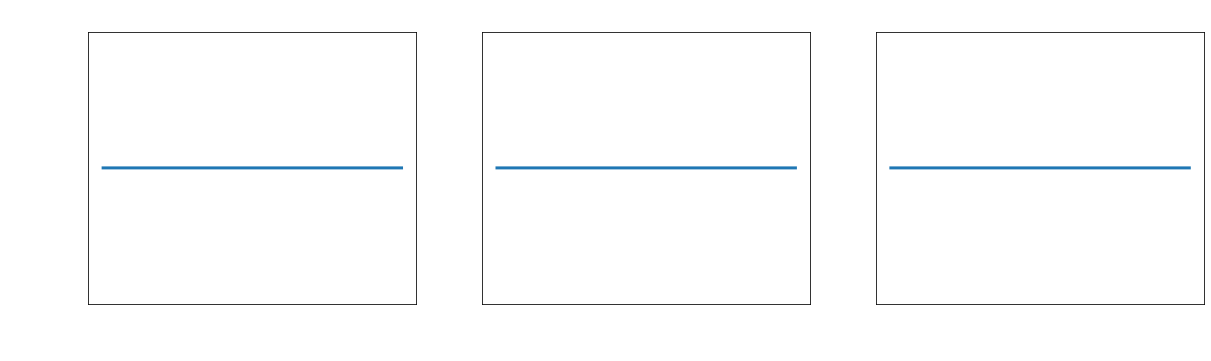

In [34]:
import matplotlib.pyplot as mpl

T = np.arange(0, int(y.shape[0]/Fs[0]), 1/Fs[0])
color = "white"
mpl.rcParams.update({'text.color' : color,
                     'axes.labelcolor' : color,
                     'xtick.color': color, 
                     'ytick.color': color})
fig, (ax1, ax2, ax3) = mpl.subplots(1, 3, figsize = (20, 5))

ax1.plot(T, state[0, :], linewidth = 3.0)
ax1.set_title("X Position over time", fontsize = 25)
ax1.set_ylabel("X(m), Y(m), Z(m)", fontsize = 25)
ax1.tick_params(axis='x', labelsize = 15)
ax1.tick_params(axis='y', labelsize = 15)

ax2.plot(T, state[1, :], linewidth = 3.0)
ax2.set_title("Y Position over time", fontsize = 25)
ax2.set_xlabel("Time(s)", fontsize = 25)
ax2.tick_params(axis='x', labelsize = 15)
ax2.tick_params(axis='y', labelsize = 15)

ax3.plot(T, state[2, :], linewidth = 3.0)
ax3.set_title("Z Position over time", fontsize = 25)
ax3.tick_params(axis='x', labelsize = 15)
ax3.tick_params(axis='y', labelsize = 15)

mpl.show()

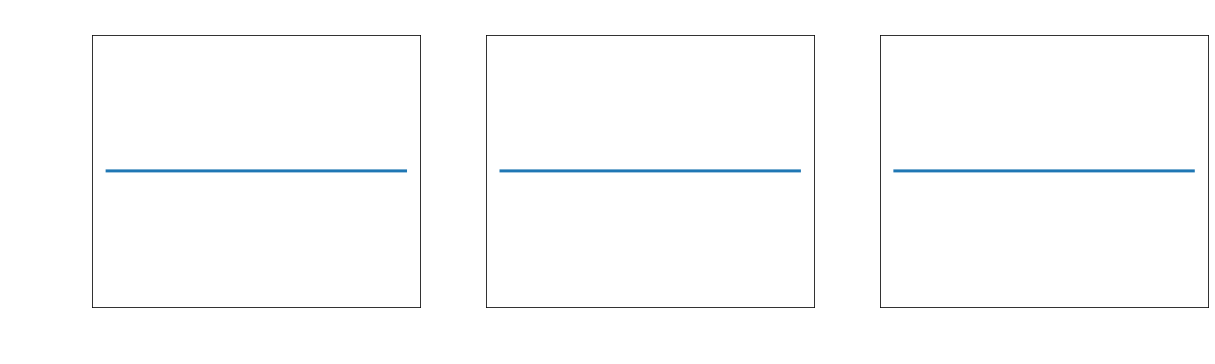

In [35]:
color = "white"
mpl.rcParams.update({'text.color' : color,
                     'axes.labelcolor' : color,
                     'xtick.color': color, 
                     'ytick.color': color})
fig, (ax1, ax2, ax3) = mpl.subplots(1, 3, figsize = (20, 5))

ax1.plot(T, state[6, :], linewidth = 3.0)
ax1.set_title(r'$\theta$ (roll) over time', fontsize = 25)
ax1.set_ylabel(r'$\theta^\circ, \phi^\circ, \psi^\circ$', fontsize = 25)
ax1.tick_params(axis='x', labelsize = 15)
ax1.tick_params(axis='y', labelsize = 15)

ax2.plot(T, state[7, :], linewidth = 3.0)
ax2.set_title(r'$\phi$ (pitch) over time', fontsize = 25)
ax2.set_xlabel("Time(s)", fontsize = 25)
ax2.tick_params(axis='x', labelsize = 15)
ax2.tick_params(axis='y', labelsize = 15)

ax3.plot(T, state[8, :], linewidth = 3.0)
ax3.set_title(r'$\psi$ (yaw) over time', fontsize = 25)
ax3.tick_params(axis='x', labelsize = 15)
ax3.tick_params(axis='y', labelsize = 15)

mpl.show()

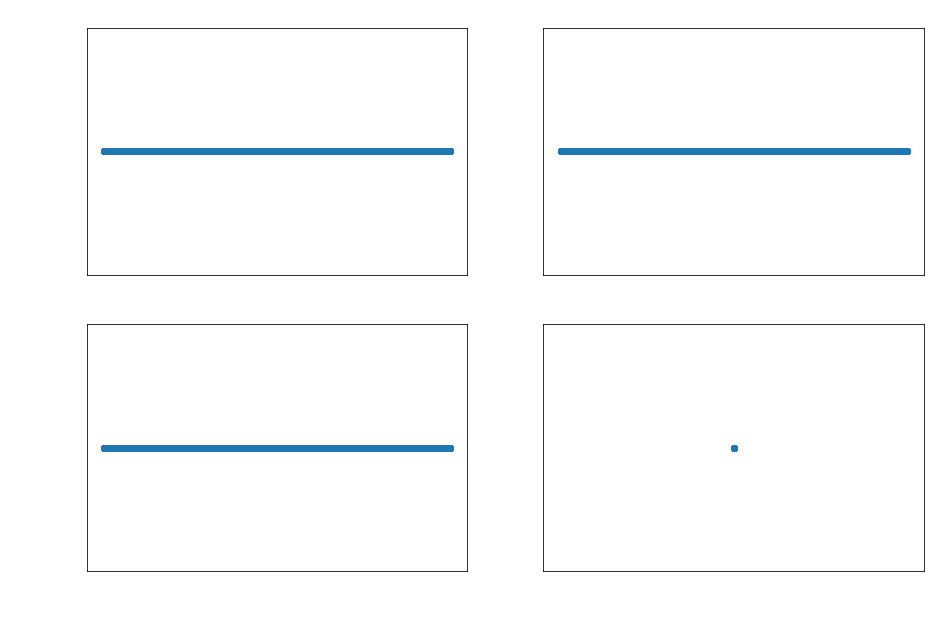

In [36]:
color = "white"
mpl.rcParams.update({'text.color' : color,
                     'axes.labelcolor' : color,
                     'xtick.color': color, 
                     'ytick.color': color})
fig, ((ax1, ax2), (ax3, ax4)) = mpl.subplots(2, 2, figsize = (15, 10))

ax1.plot(T, LLA[0, :], '-o')
ax1.set_title("Lat over time", fontsize = 20)
ax1.set_ylabel(r'$Lat^\circ, Long^\circ$', fontsize = 20)
ax1.tick_params(axis='x', labelsize = 15)
ax1.tick_params(axis='y', labelsize = 15)

ax2.plot(T, LLA[1, :], '-o')
ax2.set_title("Long over time", fontsize = 20)
ax2.tick_params(axis='x', labelsize = 15)
ax2.tick_params(axis='y', labelsize = 15)

ax3.plot(T, LLA[2, :], '-o')
ax3.set_title("Altitude Profile", fontsize = 20)
ax3.set_xlabel("Time(s)", fontsize = 20)
ax3.set_ylabel(r'h(ft), $Lat^\circ$', fontsize = 20)
ax3.tick_params(axis='x', labelsize = 15)
ax3.tick_params(axis='y', labelsize = 15)

ax4.plot(LLA[1, :], LLA[0, :], '-o')
ax4.set_title("Flight Profile Overview", fontsize = 20)
ax4.set_xlabel(r'$Long^\circ$', fontsize = 20)
ax4.tick_params(axis='x', labelsize = 15)
ax4.tick_params(axis='y', labelsize = 15)

mpl.show()

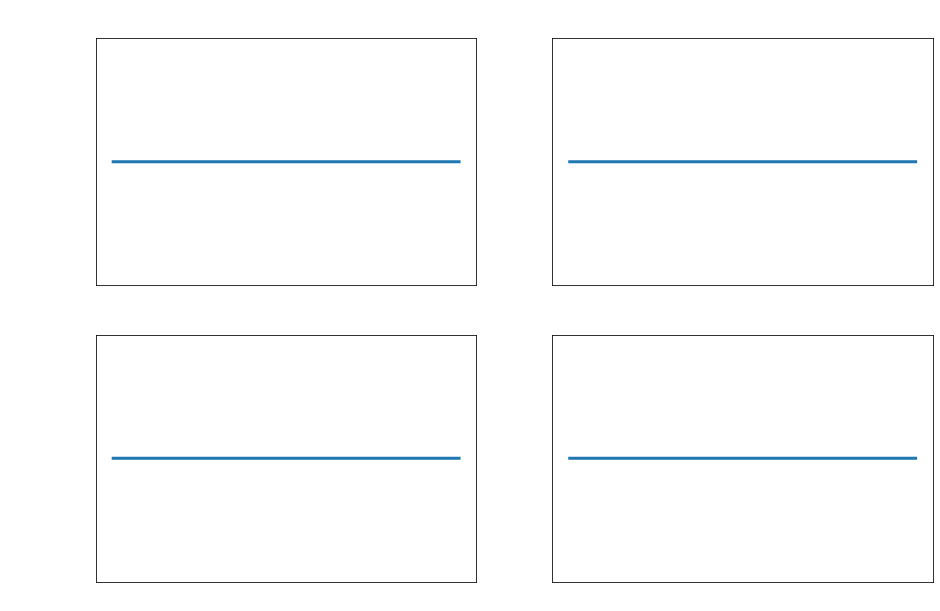

In [37]:
color = "white"
mpl.rcParams.update({'text.color' : color,
                     'axes.labelcolor' : color,
                     'xtick.color': color, 
                     'ytick.color': color})
fig, ((ax1, ax2), (ax3, ax4)) = mpl.subplots(2, 2, figsize = (15, 10))

ax1.plot(T, state[3, :], linewidth = 3.0)
ax1.set_title(r'$V_{x}$ over time', fontsize = 25)
ax1.set_ylabel(r'$V_{x}(m/s), V_{y}(m/s), V_{z}(m/s)$', fontsize = 25)
ax1.tick_params(axis='x', labelsize = 15)
ax1.tick_params(axis='y', labelsize = 15)

ax2.plot(T, state[4, :], linewidth = 3.0)
ax2.set_title(r'$V_{y}$ over time', fontsize = 25)
ax2.tick_params(axis='x', labelsize = 15)
ax2.tick_params(axis='y', labelsize = 15)

ax3.plot(T, state[5, :], linewidth = 3.0)
ax3.set_title(r'$V_{z}$ over time', fontsize = 25)
ax3.tick_params(axis='x', labelsize = 15)
ax3.tick_params(axis='y', labelsize = 15)

velocity_norm = np.zeros(T.shape)
for index in range(0, T.shape[0]):
    velocity_norm[index] = np.linalg.norm(state[3:6, index])
ax4.plot(T, velocity_norm, linewidth = 3.0)
ax4.set_title(r'$||V||_{2}$ over time', fontsize = 25)
ax4.tick_params(axis='x', labelsize = 15)
ax4.tick_params(axis='y', labelsize = 15)

mpl.show()

In [14]:
KF.x

(9, 1)

In [82]:
obs = np.array(observationsNumpied[0].reshape(observationsNumpied.shape[1], 1))
o = obs[3:, :]
obs_ECEF = ECEF02ECEF(o, GPS_time[0])
obs_ECEF

array([[ 5.15680802e-05],
       [-2.57996861e-04],
       [-8.75642367e-05]])

In [111]:
a = obs[0:3, :]
rot_matrix = ECEF2body(a, E0[0][0], E0[0][1], E0[0][2])
rot_matrix = np.array(list(rot_matrix[:, :]), dtype=np.float)
a_body = np.dot(np.linalg.inv(rot_matrix), a)
a_body

/tmp/ipykernel_5379/3522207801.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rot_matrix = np.array(list(rot_matrix[:, :]), dtype=np.float)


array([[-1.57865992e-03],
       [-2.70456696e-04],
       [-9.80979224e+00]])

In [108]:
rot_matrix

array([[array([0.99640435]), array([0.08472522]),
        array([3.73815446e-08])],
       [array([-0.08472522]), array([0.99640435]), array([0.])],
       [array([-3.72471338e-08]), array([-3.16715945e-09]), array([1.])]],
      dtype=object)

In [23]:
y

,Time (GPS),Spec force 1 (m/s^2),Spec force 2 (m/s^2),Spec force 3 (m/s^2),Rot speed 1 (rad/s),Rot speed 2 (rad/s),Rot speed 3 (rad/s)
0,1.270469e+09,-0.001596,-0.000136,-9.809792,0.000260,0.000038,-0.000088
1,1.270469e+09,-0.001537,-0.000101,-9.809655,0.000260,0.000038,-0.000088
2,1.270469e+09,-0.001628,-0.000043,-9.809746,0.000260,0.000038,-0.000088
3,1.270469e+09,-0.001708,-0.000137,-9.809631,0.000260,0.000038,-0.000088
4,1.270469e+09,-0.001788,-0.000209,-9.809714,0.000260,0.000038,-0.000088
...,...,...,...,...,...,...,...
59995,1.270469e+09,0.029062,0.006589,-9.805384,0.000241,0.000034,-0.000086
59996,1.270469e+09,0.029190,0.006538,-9.805448,0.000241,0.000034,-0.000086
59997,1.270469e+09,0.029223,0.006685,-9.805448,0.000241,0.000034,-0.000086
59998,1.270469e+09,0.029289,0.006642,-9.805557,0.000241,0.000034,-0.000086


In [25]:
u=0.25 * np.ones([6, 1])
u

array([[0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25]])

In [41]:
R

,Spec force 1 (m/s^2),Spec force 2 (m/s^2),Spec force 3 (m/s^2),Rot speed 1 (rad/s),Rot speed 2 (rad/s),Rot speed 3 (rad/s)
Spec force 1 (m/s^2),1.689597e-04,-2.724399e-05,4.484966e-06,-6.742504e-08,-1.397567e-08,5.982325e-09
Spec force 2 (m/s^2),-2.724399e-05,1.001582e-04,-2.572603e-06,-2.972897e-09,-6.807301e-10,-2.771300e-10
Spec force 3 (m/s^2),4.484966e-06,-2.572603e-06,4.125666e-05,7.643832e-10,1.069672e-10,-7.693817e-12
Rot speed 1 (rad/s),-6.742504e-08,-2.972897e-09,7.643832e-10,3.195282e-11,6.626592e-12,-2.736986e-12
Rot speed 2 (rad/s),-1.397567e-08,-6.807301e-10,1.069672e-10,6.626592e-12,1.374920e-12,-5.676804e-13
Rot speed 3 (rad/s),5.982325e-09,-2.771300e-10,-7.693817e-12,-2.736986e-12,-5.676804e-13,2.389832e-13


In [42]:
KF.Q

array([[7.5e-09, 0.0e+00, 0.0e+00, 1.5e-06, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00],
       [0.0e+00, 7.5e-09, 0.0e+00, 0.0e+00, 1.5e-06, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00],
       [0.0e+00, 0.0e+00, 7.5e-09, 0.0e+00, 0.0e+00, 1.5e-06, 0.0e+00,
        0.0e+00, 0.0e+00],
       [1.5e-06, 0.0e+00, 0.0e+00, 3.0e-04, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00],
       [0.0e+00, 1.5e-06, 0.0e+00, 0.0e+00, 3.0e-04, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00],
       [0.0e+00, 0.0e+00, 1.5e-06, 0.0e+00, 0.0e+00, 3.0e-04, 0.0e+00,
        0.0e+00, 0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 3.0e-04,
        0.0e+00, 0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        3.0e-04, 0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 3.0e-04]])